In [1]:
#!/usr/bin/env python

# nighttime_plots.ipynb

In [1]:
'''
    File name: nighttime_plots.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 04.07.2024
    Date last modified: 04.07.2024

    ############################################################## 
    Purpose:

    This program reads in data that was pre-processed by:
    papers/2024/2024_WBGT_Climate-Change/programs/night_min/nighttime_minima.py
    
'''

'\n    File name: nighttime_plots.ipynb\n    Author: Andreas Prein\n    E-mail: prein@ucar.edu\n    Date created: 04.07.2024\n    Date last modified: 04.07.2024\n\n    ############################################################## \n    Purpose:\n\n    This program reads in data that was pre-processed by:\n    papers/2024/2024_WBGT_Climate-Change/programs/night_min/nighttime_minima.py\n    \n'

In [2]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import pickle
import time
import xarray as xr
from tqdm import tqdm
import matplotlib.gridspec as gridspec

In [3]:
datasets = ['ERA5', 'CONUS404_ctr', 'CONUS404_pgw']

flag_thresholds = [29, 31, 32]

data_dir = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/nightime_stats/'

time_c404_ctr = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2020, 12, 31, 23), freq='h')
years_ctr = np.unique(time_c404_ctr.year)
time_c404_pgw = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2020, 12, 31, 23), freq='h')
years_pgw = np.unique(time_c404_pgw.year)
time_era5 = pd.date_range(datetime.datetime(1950, 1, 1, 0), 
                              end=datetime.datetime(2019, 12, 31, 23), freq='h')
era_years = np.unique(time_era5.year)

### Load the observed historic annual global temperature record

In [4]:
data = pd.read_csv('/glade/u/home/prein/papers/2024/2024_WBGT_Climate-Change/data/NASA_global-av_t2m/graph.txt', delimiter=r"\s+", header=0, skiprows=[0,1,2,4])

### LOAD GLOBAL AVERAGE T2M FROM LENS
##### this data was processed by Ming Ge

In [5]:
StartDay = datetime.datetime(1850, 1, 15,1)
StopDay = datetime.datetime(2101, 1, 15,0)
Time=pd.date_range(StartDay, end=StopDay, freq='M')
Time_years=pd.date_range(StartDay, end=StopDay, freq='Y')
years = np.unique(Time.year)

reference_period = [1950, 1980]

/glade/derecho/scratch/prein/tmp/ipykernel_54313/182532327.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  Time=pd.date_range(StartDay, end=StopDay, freq='M')
/glade/derecho/scratch/prein/tmp/ipykernel_54313/182532327.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  Time_years=pd.date_range(StartDay, end=StopDay, freq='Y')


In [6]:
lens2_t2m_dir = '/glade/campaign/mmm/c3we/mingge/DOD/LENS2/'
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_185001-197912.nc', mode='r')
TREFMNAV_hist = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_198001-201412.nc', mode='r')
TREFMNAV_cur = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_201501-210012.nc', mode='r')
TREFMNAV_fut = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()

ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_185001-197912.nc', mode='r')
TREFMXAV_hist = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_198001-201412.nc', mode='r')
TREFMXAV_cur = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_201501-210012.nc', mode='r')
TREFMXAV_fut = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()

In [7]:
TREFMNAV = np.append(TREFMNAV_hist, TREFMNAV_cur, axis=1)
TREFMNAV = np.append(TREFMNAV, TREFMNAV_fut, axis=1)
TREFMXAV = np.append(TREFMXAV_hist, TREFMXAV_cur, axis=1)
TREFMXAV = np.append(TREFMXAV, TREFMXAV_fut, axis=1)
lens2_t2m = (TREFMNAV + TREFMXAV) / 2.

lens2_t2m_y = np.mean(np.reshape(lens2_t2m, (lens2_t2m.shape[0], int(lens2_t2m.shape[1]/12), 12)), axis=2)

ref_t2m = np.mean(lens2_t2m_y[:,(years >= reference_period[0]) & (years <= reference_period[1])])
time_to_t2m = np.mean(lens2_t2m_y, axis=0) - ref_t2m

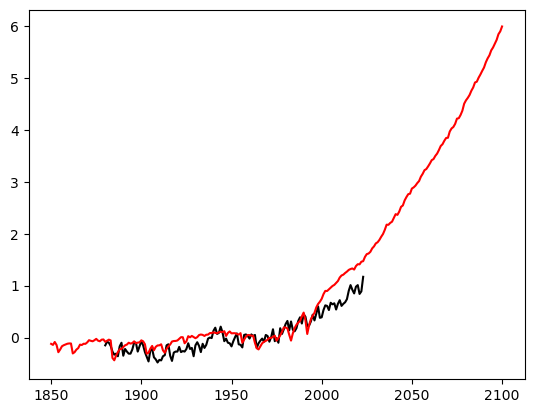

In [8]:
plt.plot(data['Year'], data['No_Smoothing'], c='k', label='NASA')
plt.plot(years, time_to_t2m, c='r', label='LENS2')

In [9]:
dc_hist = np.arange(0,1.5,0.1)
dc_pgw = np.arange(0,3.5,0.1)
dc = 0.5 # deg. C

ref_period = [1950,1979]

era5_ref = np.mean(data['No_Smoothing'][(data['Year'] >= ref_period[0]) & (data['Year'] <= ref_period[1])])
era5_warming = np.squeeze(np.array([data['No_Smoothing'][data['Year'] == yy] - era5_ref for yy in range(1980,2023,1)]))

lens2_ref = np.mean(time_to_t2m[(years >= ref_period[0]) & (years <= ref_period[1])])
lens2_warming = np.array([time_to_t2m[years == yy][0] - lens2_ref for yy in range(2022,2022+len(np.unique(time_c404_pgw.year)),1)])


pgw_warming = np.zeros((len(years_ctr))); pgw_warming[:] = np.nan
for yy in range(len(years_ctr)):
    lens_hist = (years <= years_ctr[yy] + 5) & (years >= years_ctr[yy] - 5)
    lens_fut = (years <= years_ctr[yy] + 40 + 5) & (years >= years_ctr[yy] + 40 - 5)
    pgw_warming[yy] = data['No_Smoothing'][years_ctr[yy] == data['Year']] + np.mean(time_to_t2m[lens_fut]) - np.mean(time_to_t2m[lens_hist])

/glade/derecho/scratch/prein/tmp/ipykernel_54313/2108212070.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pgw_warming[yy] = data['No_Smoothing'][years_ctr[yy] == data['Year']] + np.mean(time_to_t2m[lens_fut]) - np.mean(time_to_t2m[lens_hist])


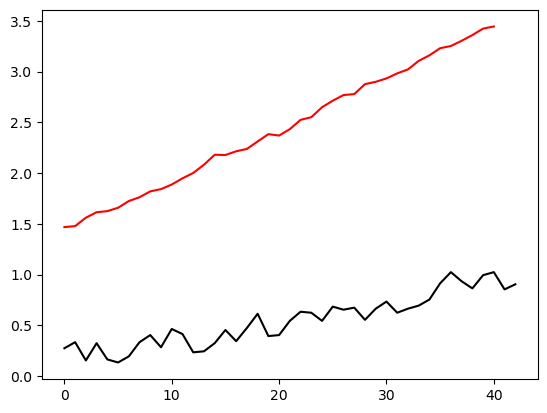

In [10]:
plt.plot(era5_warming, c='k')
plt.plot(lens2_warming, c='r')
# plt.plot(, c='b')

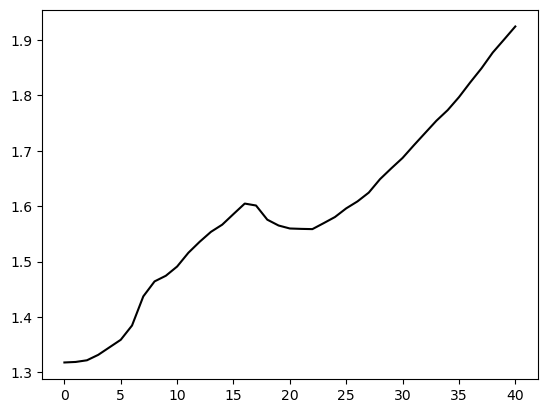

In [11]:
plt.plot(pgw_warming - era5_warming[:len(pgw_warming)], c='k')


### Load ERA5 data

In [14]:
# read ERA5 coordinates
data = np.load(data_dir + '/2019_ERA5_nightime_stats.npz')
lon_e5 = data['lon']
lat_e5 = data['lat']

lon_e5_2d, lat_e5_2d = np.meshgrid(lon_e5-360, lat_e5)

era5_nightmax = np.zeros((len(era_years), 4, lon_e5_2d.shape[0], lon_e5_2d.shape[1])); era5_nightmax[:] = np.nan
era5_night_exceed = np.zeros((len(era_years), 4, lon_e5_2d.shape[0], lon_e5_2d.shape[1])); era5_night_exceed[:] = np.nan
for yy in tqdm(range(len(era_years))):
    if os.path.exists(data_dir + '/'+str(era_years[yy])+'_ERA5_nightime_stats.npz'):
        data = np.load(data_dir + '/'+str(era_years[yy])+'_ERA5_nightime_stats.npz')
        era5_nightmax[yy,:] = np.max(data['wbgt_night_max'], axis=0)
        era5_night_exceed[yy,:] = np.sum(data['night_exceedance'], axis=0)

100%|██████████| 70/70 [00:09<00:00,  7.35it/s] 


# Load CONUS404 ctr

In [15]:
data = np.load(data_dir + '/2019_CONUS404_ctr_nightime_stats.npz')
lon_wrf = data['lon']
lon_wrf = data['lat']
flag_thresholds = data['flag_thresholds']

wrf_ctr_nightmax = np.zeros((len(years_ctr), len(flag_thresholds), lon_wrf.shape[0], lon_wrf.shape[1])); wrf_ctr_nightmax[:] = np.nan
wrf_ctr_night_exceed = np.zeros((len(years_ctr), len(flag_thresholds), lon_wrf.shape[0], lon_wrf.shape[1])); wrf_ctr_night_exceed[:] = np.nan
for yy in tqdm(range(len(years_ctr))):
    data = np.load(data_dir + '/'+str(years_ctr[yy])+'_CONUS404_ctr_nightime_stats.npz')
    wrf_ctr_nightmax[yy,:] = np.max(data['wbgt_night_max'], axis=0)
    wrf_ctr_night_exceed[yy,:] = np.sum(data['night_exceedance'], axis=0)

 98%|█████████▊| 40/41 [01:23<00:02,  2.09s/it]


FileNotFoundError: [Errno 2] No such file or directory: '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/nightime_stats//2020_CONUS404_ctr_nightime_stats.npz'

array([296.2975274, 296.2975274, 296.2975274, 296.2975274])

# Load CONUS404 pgw

In [16]:
wrf_pgw_nightmax = np.zeros((len(years_ctr), len(flag_thresholds), lon_wrf.shape[0], lon_wrf.shape[1])); wrf_pgw_nightmax[:] = np.nan
wrf_pgw_night_exceed = np.zeros((len(years_ctr), len(flag_thresholds), lon_wrf.shape[0], lon_wrf.shape[1])); wrf_pgw_night_exceed[:] = np.nan
for yy in tqdm(range(len(years_ctr))):
    data = np.load(data_dir + '/'+str(years_ctr[yy])+'_CONUS404_pgw_nightime_stats.npz')
    wrf_pgw_nightmax[yy,:] = np.max(data['wbgt_night_max'], axis=0)
    wrf_pgw_night_exceed[yy,:] = np.sum(data['night_exceedance'], axis=0)

 98%|█████████▊| 40/41 [01:30<00:02,  2.26s/it]


FileNotFoundError: [Errno 2] No such file or directory: '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/nightime_stats//2020_CONUS404_pgw_nightime_stats.npz'

### Plot exceedance frequency and their changes for different warming levels

In [17]:
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.feature as cf
import cartopy.crs as ccrs
GEO_EM_D1 = '/glade/u/home/prein/projects/2020/2020_CONUS404/data/wrfconstants_d01_CONUS404.nc4'
ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT")
LU = getvar(ncfile, "LU_INDEX")
cart_proj = get_cartopy(HGT_M)
ncid.close()

In [29]:
from matplotlib import colors as c
### map for exceedances
wbgt_colros = ['#ffffff','#e0ecf4','#bfd3e6','#9ebcda','#8c96c6','#8c6bb1','#88419d','#810f7c','#4d004b']
ticks_color_exc = [0, 1, 5,10,20,40,80,160, 320]
cMap_exc = c.ListedColormap(wbgt_colros)

### map for changes
wbgt_change = ['#deebf7','#ffffff','#efe49c', '#eec068','#e87e31','#d4662e','#cf342b','#9f2027','#56140e','#821763','#992ba8','#d33ef0','#ec87f5']
ticks_color_ch = (np.array([-10, -2, 2, 5, 10, 20, 40, 90, 140, 200, 300, 400, 500])/2).astype(int)
cMap_cha = c.ListedColormap(wbgt_change)

mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: GFH_nightime.jpg


'\nsPlotName= "Fig2_"+warn_lev_names[warn_lev]+"_changes.jpg"\nfig.savefig(sPlotFile+sPlotName, dpi=700, bbox_inches=\'tight\')\n'

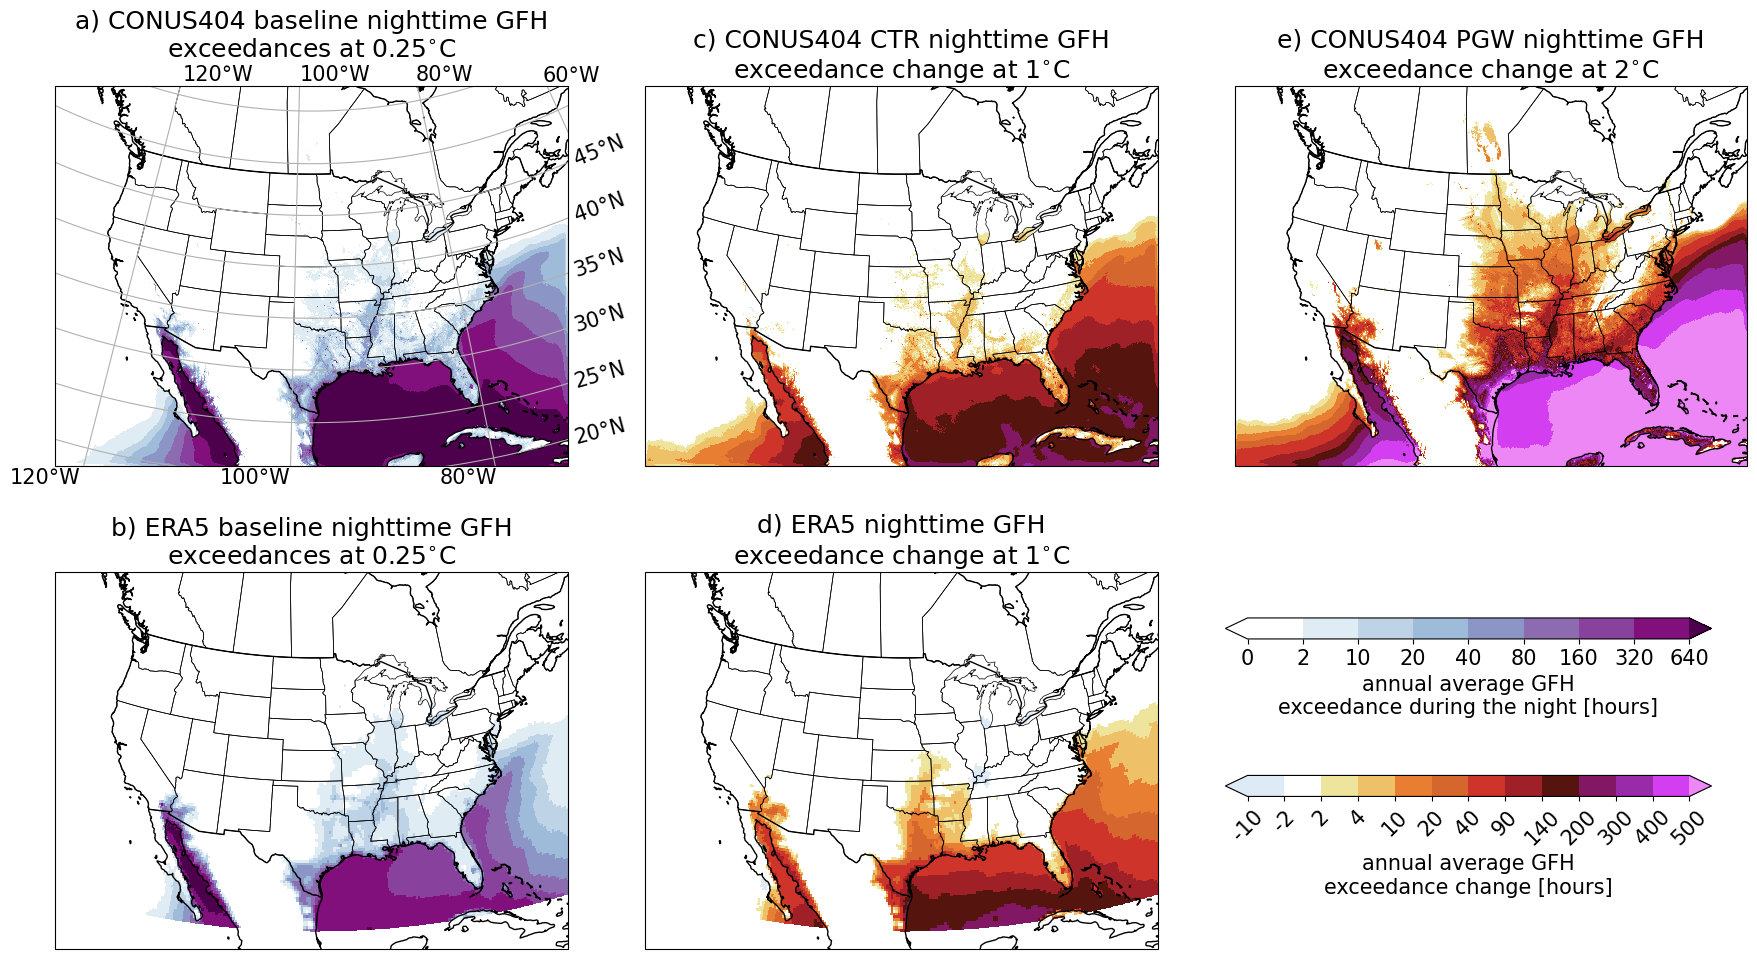

In [35]:
fig = plt.figure(figsize=(18,10.5))
plt.rcParams.update({'font.size': 15})
gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.05, right=0.99,
           bottom=0.10, top=0.93,
           wspace=0.15, hspace=0.25)

foc_region = ' '
# foc_region = ' ', 'Yuma'
warn_lev = 0 # yellow flag = 0, red flag = 1; black flag = 2 
warn_lev_names = ["GFH","YFH","RFH","BFH"]
scale_fac = [2,0.5,1,1]

# =========================
# 0.25 C warming
ax = plt.subplot(gs1[0,0], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 0.25
targ_years_ref = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title("a) CONUS404 baseline nighttime "+warn_lev_names[warn_lev]+"\nexceedances at "+str(warming_tar)+'$^{\circ}$C')
cs = ax.pcolormesh(lon_wrf, lon_wrf, 
                   np.nanmean(wrf_ctr_night_exceed[targ_years_ref[:-2],warn_lev], axis=0), 
                   transform=ccrs.PlateCarree(),
                   cmap = cMap_exc,
                   norm = mpl.colors.BoundaryNorm(np.array(ticks_color_exc) * scale_fac[warn_lev], ncolors=len(ticks_color_exc)-1, clip=False))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabel_style = {'rotation': 0}
gl.left_labels = False
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())
elif foc_region == 'Northwest':
    ax.set_extent((-130, -110, 46, 51), ccrs.PlateCarree())

# =========================
# 0.25 C warming ERA5
ax = plt.subplot(gs1[1,0], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 0.25
targ_years_ref = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title("b) ERA5 baseline nighttime "+warn_lev_names[warn_lev]+"\nexceedances at "+str(warming_tar)+'$^{\circ}$C')

cs = ax.pcolormesh(lon_e5, lat_e5, 
                   np.nanmean(era5_night_exceed[np.isin(era_years, years_ctr),warn_lev,:][targ_years_ref[:-3],:], axis=0), 
                   transform=ccrs.PlateCarree(),
                   cmap = cMap_exc,
                   norm = mpl.colors.BoundaryNorm(np.array(ticks_color_exc) * scale_fac[warn_lev], ncolors=len(ticks_color_exc)-1, clip=False))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
ax.set_extent((-124, -72.5, 21, 55), ccrs.PlateCarree())
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())
elif foc_region == 'Northwest':
    ax.set_extent((-130, -110, 46, 51), ccrs.PlateCarree())

# Add a color bar
CbarAx = plt.axes([0.7, 0.4, 0.27, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
cb.set_label("annual average "+warn_lev_names[warn_lev]+"\nexceedance during the night [hours]", fontsize=15)
cb.set_ticks(np.array(ticks_color_exc) * scale_fac[warn_lev])
cb.set_ticklabels(np.array(ticks_color_exc) * scale_fac[warn_lev])



# =========================
# 1 C warming change
ax = plt.subplot(gs1[0,1], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 1
targ_years = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title("c) CONUS404 CTR nighttime "+warn_lev_names[warn_lev]+"\nexceedance change at "+str(warming_tar)+'$^{\circ}$C')

cs = ax.pcolormesh(lon_wrf, lon_wrf, 
                   np.nanmean(wrf_ctr_night_exceed[targ_years[:-2],warn_lev], axis=0) -
                   np.nanmean(wrf_ctr_night_exceed[targ_years_ref[:-2],warn_lev], axis=0), 
                   transform=ccrs.PlateCarree(),
                   cmap = cMap_cha,
                   norm = mpl.colors.BoundaryNorm(np.array(ticks_color_ch) * scale_fac[warn_lev], ncolors=len(ticks_color_ch)-1, clip=False))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())
elif foc_region == 'Northwest':
    ax.set_extent((-130, -110, 46, 51), ccrs.PlateCarree())


# =========================
# 1 C warming change ERA5
ax = plt.subplot(gs1[1,1], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 1
targ_years = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title("d) ERA5 nighttime "+warn_lev_names[warn_lev]+"\nexceedance change at "+str(warming_tar)+'$^{\circ}$C')

cs = ax.pcolormesh(lon_e5, lat_e5, 
                   np.nanmean(era5_night_exceed[np.isin(era_years, years_ctr),warn_lev,:][targ_years[:-3],:], axis=0) -
                   np.nanmean(era5_night_exceed[np.isin(era_years, years_ctr),warn_lev,:][targ_years_ref[:-3],:], axis=0), 
                   transform=ccrs.PlateCarree(),
                   cmap = cMap_cha,
                   norm = mpl.colors.BoundaryNorm(np.array(ticks_color_ch) * scale_fac[warn_lev], ncolors=len(ticks_color_ch)-1, clip=False))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
ax.set_extent((-124, -72.5, 21, 55), ccrs.PlateCarree())
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())
elif foc_region == 'Northwest':
    ax.set_extent((-130, -110, 46, 51), ccrs.PlateCarree())

# Add a color bar
CbarAx = plt.axes([0.7, 0.25, 0.27, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
cb.set_label("annual average " + warn_lev_names[warn_lev] + "\nexceedance change [hours]", fontsize=15)
cb.set_ticks(np.array(ticks_color_ch) * scale_fac[warn_lev])
cb.set_ticklabels(np.array(ticks_color_ch) * scale_fac[warn_lev])
cb.ax.tick_params(labelrotation=45)


# =========================
# 2 C warming change
ax = plt.subplot(gs1[0,2], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 2
targ_years = (pgw_warming[:len(years_pgw)] >= warming_tar - dc) & (pgw_warming[:len(years_pgw)] <= warming_tar + dc)
plt.title("e) CONUS404 PGW nighttime "+warn_lev_names[warn_lev]+"\nexceedance change at "+str(warming_tar)+'$^{\circ}$C')

cs = ax.pcolormesh(lon_wrf, lon_wrf, 
                   np.nanmean(wrf_pgw_night_exceed[targ_years,warn_lev], axis=0) -
                   np.nanmean(wrf_ctr_night_exceed[targ_years_ref[:-2],warn_lev], axis=0), 
                   transform=ccrs.PlateCarree(),
                   cmap = cMap_cha,
                   norm = mpl.colors.BoundaryNorm(np.array(ticks_color_ch) * scale_fac[warn_lev], ncolors=len(ticks_color_ch)-1, clip=False))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())
elif foc_region == 'Northwest':
    ax.set_extent((-130, -110, 46, 51), ccrs.PlateCarree())


sPlotFile=""

sPlotName= warn_lev_names[warn_lev]+'_nightime_exceedances.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, dpi=700, bbox_inches='tight') #, dpi=700)


"""
sPlotName= "Fig2_"+warn_lev_names[warn_lev]+"_changes.jpg"
fig.savefig(sPlotFile+sPlotName, dpi=700, bbox_inches='tight')
"""

### Plot annual maxima of daily minimum WBGT during nightime hours

In [68]:
def coarsen(data,
            factor):
    data = np.reshape(data[:int(int(data.shape[0]/factor)*factor),
                           :int(int(data.shape[1]/factor)*factor)], 
                             (int(data.shape[0]/factor),
                             factor,
                             int(data.shape[1]/factor),
                             factor))
    return np.mean(data, axis = (1,3))

def coarsen3d(data,
            factor):
    data = np.reshape(data[:,:int(int(data.shape[1]/factor)*factor),
                             :int(int(data.shape[2]/factor)*factor)], 
                             (data.shape[0],
                              int(data.shape[1]/factor),
                             factor,
                             int(data.shape[2]/factor),
                             factor))
    return np.mean(data, axis = (2,4))
gc = 5

In [69]:
from matplotlib import colors as c
wbgt_colros = ['#737373','#969696','#bdbdbd','#d9d9d9','#f0f0f0','#ffff99', '#ffcc00', '#ff9933', '#ff6666', '#ff0000', '#800000', '#cc3399','#990099', '#ff00ff']

foc_region = '' #'Yuma'
if foc_region != 'Yuma':
    ticks_color = np.array(range(16, 16+len(wbgt_colros), 1))
else:
    ticks_color = np.array(range(28, 28+len(wbgt_colros), 1))
cMap = c.ListedColormap(wbgt_colros)

mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: annual-max-nightime-minimum_WBGT_change.jpg


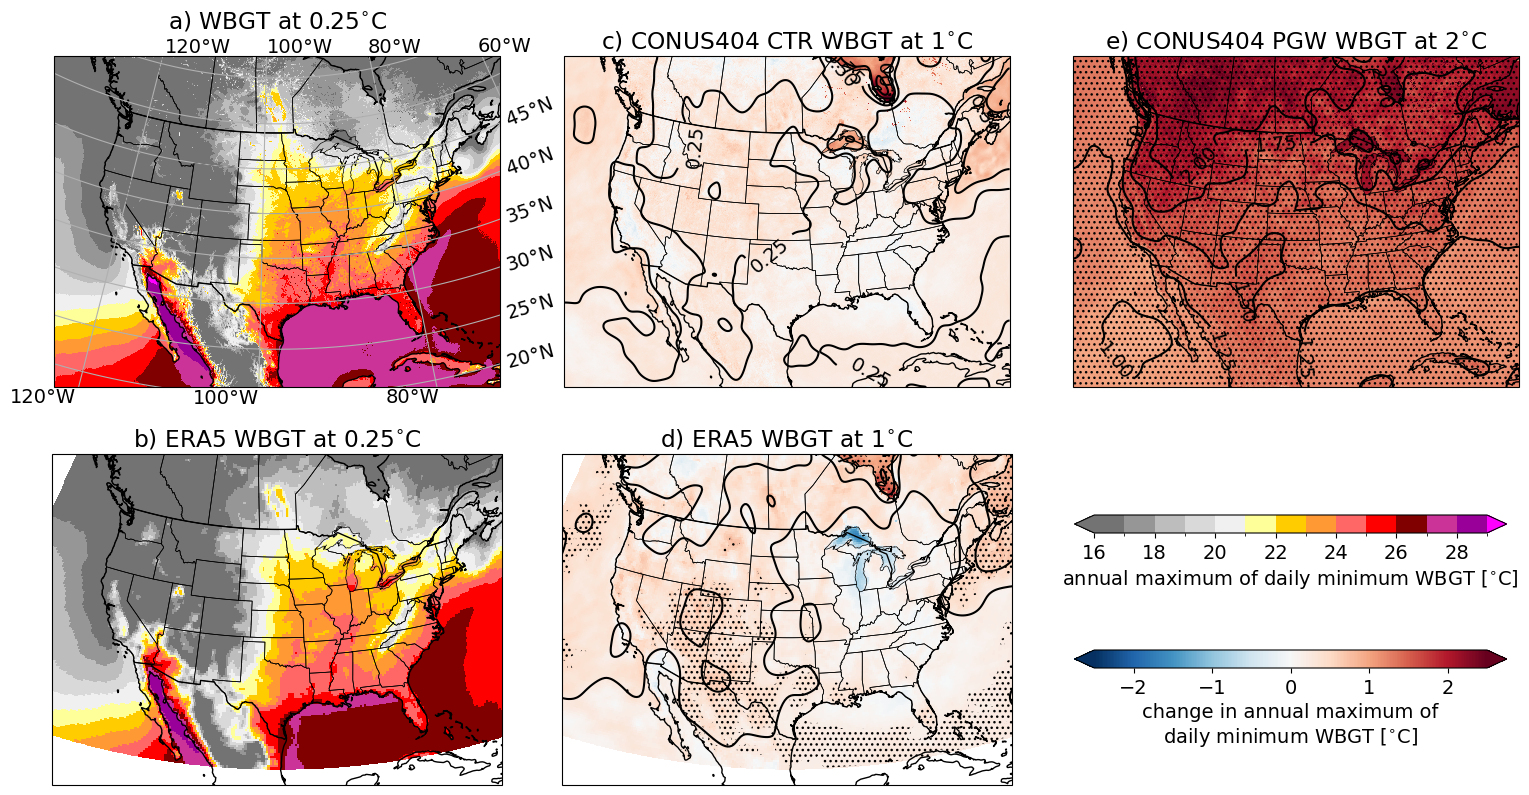

In [82]:
fig = plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 14})
gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.05, right=0.99,
           bottom=0.12, top=0.93,
           wspace=0.05, hspace=0.2)

# =========================
# 0.25 C warming
ax = plt.subplot(gs1[0,0], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 0.25
targ_years_ref = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title('a) WBGT at '+str(warming_tar)+'$^{\circ}$C')

cs = ax.pcolormesh(lon_wrf, lat_wrf, 
                   np.nanmean(wrf_ctr_nightmax[targ_years_ref[:-2],0], axis=0)-273.15, 
                   cmap=cMap, transform=ccrs.PlateCarree(),
                   norm = mpl.colors.BoundaryNorm(ticks_color, ncolors=len(ticks_color)-1, clip=False))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.left_labels = False
gl.xlabel_style = {'rotation': 0}



# =========================
# 0.25 C warming ERA5
ax = plt.subplot(gs1[1,0], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 0.25
targ_years_ref = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title('b) ERA5 WBGT at '+str(warming_tar)+'$^{\circ}$C')

cs = ax.pcolormesh(lon_e5, lat_e5, 
                   np.nanmean(era5_nightmax[np.isin(era_years, years_ctr),warn_lev,:][targ_years_ref[:-3],:], axis=0)-273.15, 
                   cmap=cMap, transform=ccrs.PlateCarree(),
                   norm = mpl.colors.BoundaryNorm(ticks_color, ncolors=len(ticks_color)-1, clip=False))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
ax.set_extent((-124, -72.5, 21, 55), ccrs.PlateCarree())
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())

# Add a color bar
CbarAx = plt.axes([0.7, 0.4, 0.27, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
cb.set_label('annual maximum of daily minimum WBGT [$^{\circ}$C]', fontsize=14)

# =========================
# 1 C warming change
ax = plt.subplot(gs1[0,1], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 1
targ_years = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title('c) CONUS404 CTR WBGT at '+str(warming_tar)+'$^{\circ}$C')

change_signal = np.nanmean(wrf_ctr_nightmax[targ_years[:-2],0], axis=0) - \
                   np.nanmean(wrf_ctr_nightmax[targ_years_ref[:-2],0], axis=0)
cs = ax.pcolormesh(lon_wrf, lat_wrf, 
                   change_signal, 
                   cmap='RdBu_r', vmin=-2.5,vmax=2.5, transform=ccrs.PlateCarree())

sig = scipy.stats.mannwhitneyu(coarsen3d(wrf_ctr_nightmax[targ_years[:-2],0], gc), 
                             coarsen3d(wrf_ctr_nightmax[targ_years_ref[:-2],0], gc), axis = 0)
# add significance layer
ax.contourf(
    coarsen(lon_wrf, gc), coarsen(lat_wrf, gc), 
    sig.pvalue < 0.05,
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=['...',''],
)

# show contour lines of smoothed field
CS = plt.contour(lon_wrf, lat_wrf,
                   scipy.ndimage.gaussian_filter(change_signal, 20),
                   levels = (0.25,0.5,0.75,1,1.25,1.5,1.75,2), transform=ccrs.PlateCarree(), colors='black')
ax.clabel(CS, inline=1, fontsize=14)

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())


# =========================
# 1 C warming change ERA5
ax = plt.subplot(gs1[1,1], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 1
targ_years = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title('d) ERA5 WBGT at '+str(warming_tar)+'$^{\circ}$C')

change_signal = np.nanmean(era5_nightmax[np.isin(era_years, years_ctr),warn_lev,:][targ_years[:-3],:], axis=0) - \
                   np.nanmean(era5_nightmax[np.isin(era_years, years_ctr),warn_lev,:][targ_years_ref[:-3],:], axis=0)
cs = ax.pcolormesh(lon_e5, lat_e5, 
                   change_signal, 
                   cmap='RdBu_r', vmin=-2.5,vmax=2.5, transform=ccrs.PlateCarree())

sig = scipy.stats.mannwhitneyu(era5_nightmax[np.isin(era_years, years_ctr),warn_lev,:][targ_years[:-3],:], 
                             era5_nightmax[np.isin(era_years, years_ctr),warn_lev,:][targ_years_ref[:-3],:], axis = 0)
# add significance layer
ax.contourf(
    lon_e5, lat_e5, 
    sig.pvalue < 0.05,
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=['...',''],
)

# show contour lines of smoothed field
CS = plt.contour(lon_e5, lat_e5, 
                   scipy.ndimage.gaussian_filter(change_signal, 5),
                   levels = (0.25,0.5,0.75,1,1.25,1.5,1.75,2), transform=ccrs.PlateCarree(), colors='black')
ax.clabel(CS, inline=1, fontsize=14)

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
ax.set_extent((-124, -72.5, 21, 55), ccrs.PlateCarree())
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())

# Add a color bar
CbarAx = plt.axes([0.7, 0.25, 0.27, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
cb.set_label('change in annual maximum of\ndaily minimum WBGT [$^{\circ}$C]', fontsize=14)


# =========================
# 2 C warming change
ax = plt.subplot(gs1[0,2], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 2
targ_years = (pgw_warming[:len(years_pgw)] >= warming_tar - dc) & (pgw_warming[:len(years_pgw)] <= warming_tar + dc)
plt.title('e) CONUS404 PGW WBGT at '+str(warming_tar)+'$^{\circ}$C')

change_signal = np.nanmean(wrf_pgw_nightmax[targ_years,0], axis=0) - \
                   np.nanmean(wrf_ctr_nightmax[targ_years_ref[:-2],0], axis=0)
cs = ax.pcolormesh(lon_wrf, lat_wrf, 
                   change_signal, 
                   cmap='RdBu_r', vmin=-2.5,vmax=2.5, transform=ccrs.PlateCarree())

sig = scipy.stats.mannwhitneyu(coarsen3d(wrf_pgw_nightmax[targ_years,0], gc), 
                             coarsen3d(wrf_ctr_nightmax[targ_years_ref[:-2],0], gc), axis = 0)
# add significance layer
ax.contourf(
    coarsen(lon_wrf, gc), coarsen(lat_wrf, gc), 
    sig.pvalue < 0.05,
    transform=ccrs.PlateCarree(),
    colors='none',
    levels=[.5,1.5],
    hatches=['...',''],
)

# show contour lines of smoothed field
CS = plt.contour(lon_wrf, lat_wrf,
                   scipy.ndimage.gaussian_filter(change_signal, 20),
                   levels = (0.25,0.5,0.75,1,1.25,1.5,1.75,2), transform=ccrs.PlateCarree(), colors='black')
ax.clabel(CS, inline=1, fontsize=14)
ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())


sPlotFile=""
sPlotName= 'annual-max-nightime-minimum_WBGT_change.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, dpi=700)

In [80]:
wrf_pgw_nightmax[targ_years,0].shape

(32, 1015, 1367)